In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage

col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','Ulnar Deviation','Radial Deviation','Grip','Abduction of Fingers','Adduction of Fingers','Supination','Pronation']

Reshape the data1~data40 to 3-D arrays having gesture names

In [3]:
import warnings
warnings.filterwarnings('ignore') # too many warnings (use DataFrame.transpose instead of DataFrame.swapaxes)
c=0
for i in range(40): # data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_patterns'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for j in range(5): # pattern1 to pattern5
        globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_patterns'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
        
        for g in range(10): # gesture1 to gesture10
            if i==0: # make a array, the first face of 3-D gesture array
                globals()['{}_signal'.format(gesture_names[g])] = globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:] # 3-D arrays after numpy.newaxis having gesture names 
                
            else: # vertically stack the 2-D arrays to the previously generated 3-D array
                globals()['{}_signal'.format(gesture_names[g])] = np.vstack([globals()['{}_signal'.format(gesture_names[g])],globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:]])

        c+=1
        #print('i:{} j:{} c:{}'.format(i+1,j+1,c))

In [4]:
Extension_signal.shape # why (196, 20000, 4) ?

(196, 20000, 4)

Process signal to classify

1. Define some filters to go through

In [5]:
def maximum(raw, box_size, mode='nearest'): # Maximum filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation denoiser
    # apply the FFT
    fft_signal = np.fft.fft(data)
    
    # reconstruct the original signal by apply the IFFT
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing technique
    window_len=11  # extend the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

2. Apply Filters

In [6]:
for i in range(196): # 196(?) samples
    for g in gesture_names: # 10 gestures
        for ch in range(4):
            if i == 0:
                globals()['{}_signal_filtered'.format(g)] = np.ndarray(globals()['{}_signal'.format(g)][:,2000:18000].shape) # make a array shape with less rest time
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),20),2)[2000:18000] # apply the filters and cut the rest time
                
            else:
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),20),2)[2000:18000] # apply the filters and cut the rest time
                

3. Draw the filtered signals to overview

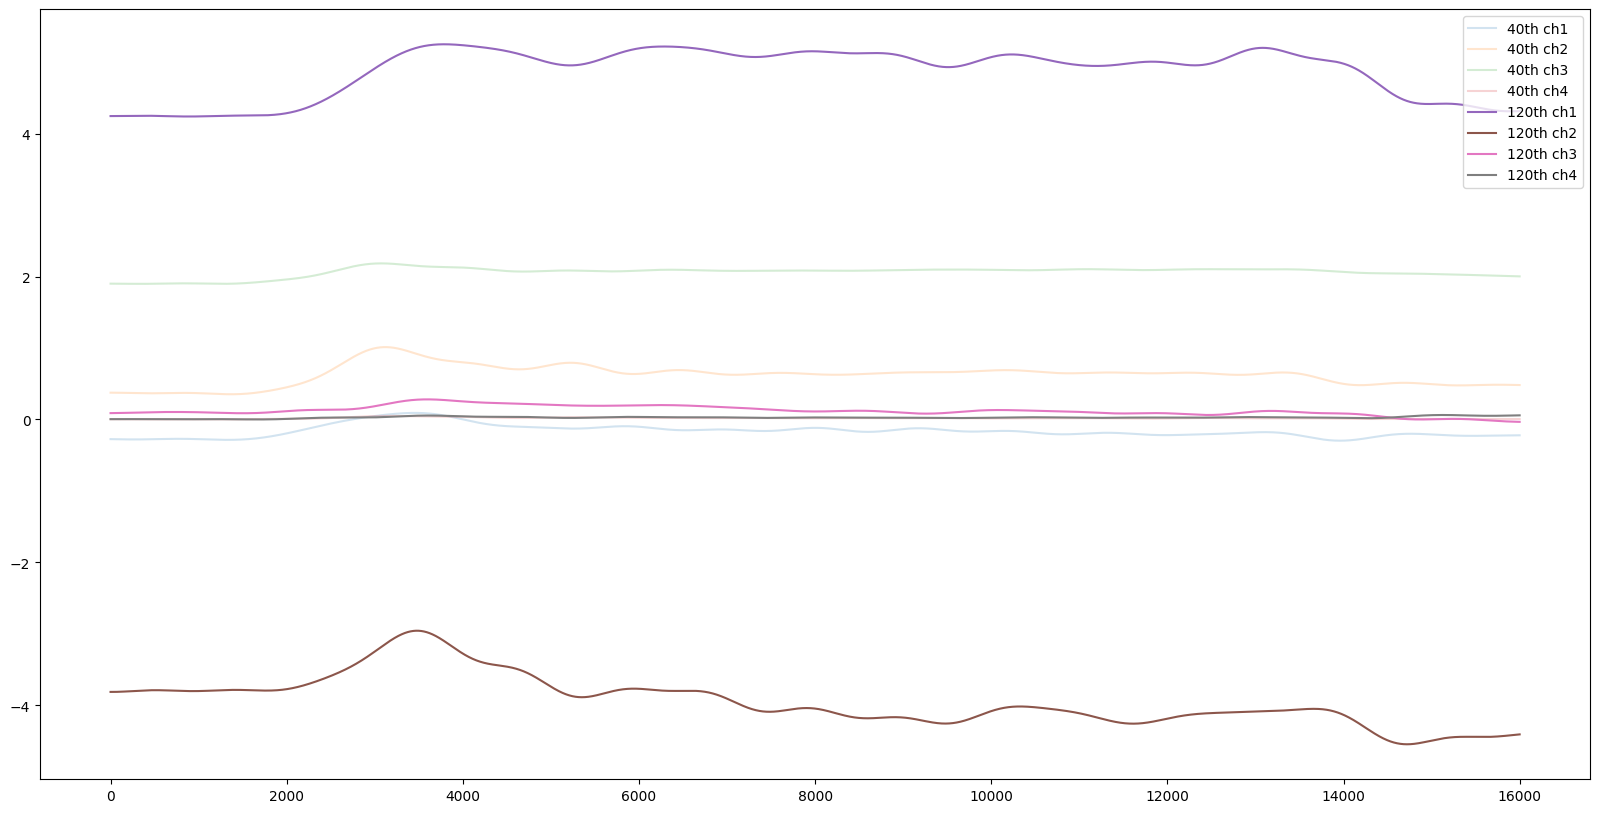

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(Extension_signal_filtered[40],label=['40th '+s for s in col_names],alpha=0.2)
ax.plot(Extension_signal_filtered[120],label=['120th '+s for s in col_names])

plt.legend()
plt.show()

    The signals of each channel show very similar shapes but different locations(y-axis)

In [8]:
# tasks to do :
# 1. find the best classifier for the same pattern but different range of values
#    (StandardScaler-standardization, MinMaxScaler-normalization,
#     PCA-dimensional reduction, t-SNE-dimensional reduction)
# 2. classify the data with varying time ranges 
#    ('Down-Scaling', 'Up-Scaling')
# 3. repeat classifying with different window sizes to get the best

Standardization and Normalization

1. StandardScaler sets values have mean to 0 with standard deviation

In [16]:
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()

X40_std = standardscaler.fit_transform(Extension_signal_filtered[40])
X70_std = standardscaler.fit_transform(Extension_signal_filtered[70])

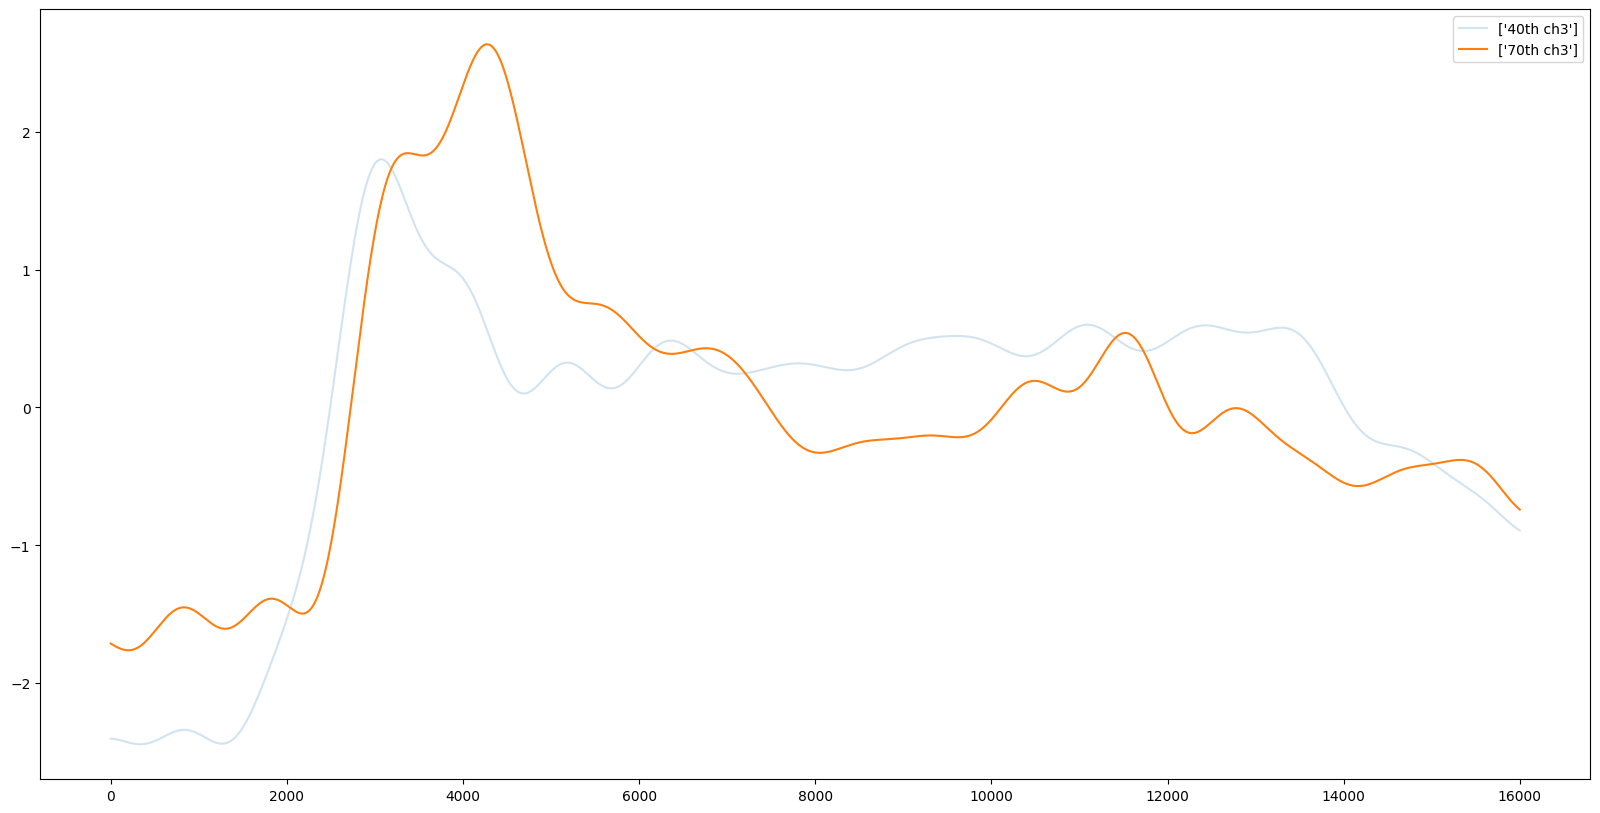

In [22]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_std[:,2],label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X70_std[:,2],label=['70th '+col_names[2]])

plt.legend()
plt.show()

2. MinMaxScaler sets minimum signal to 0, maximum signal to 1, and other values between them

In [18]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

X40_mm = minmaxscaler.fit_transform(Extension_signal_filtered[40])
X70_mm = minmaxscaler.fit_transform(Extension_signal_filtered[70])

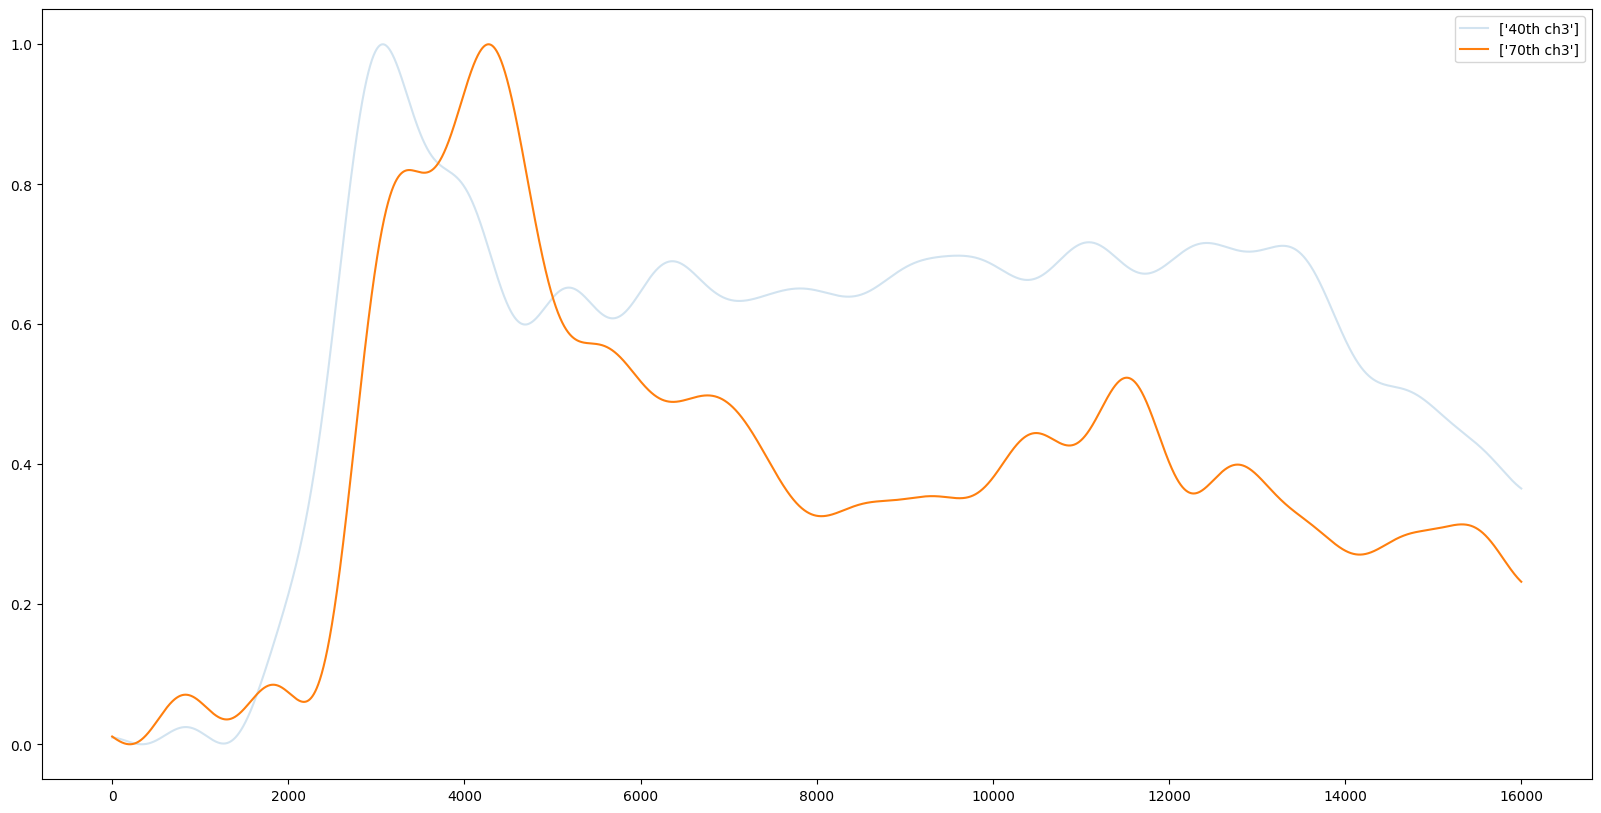

In [33]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_mm[:,2],label=['40th '+col_names[2]],alpha=0.2)
ax.plot(X70_mm[:,2],label=['70th '+col_names[2]])

plt.legend()
plt.show()

    Using MinMaxScaler seems more suitable because the ranges of signal strength have personal difference

PCA and t-SNE

1. PCA(Principal Component Analysis)

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X40_pca = pca.fit_transform(X40_mm)
X70_pca = pca.fit_transform(X70_mm)

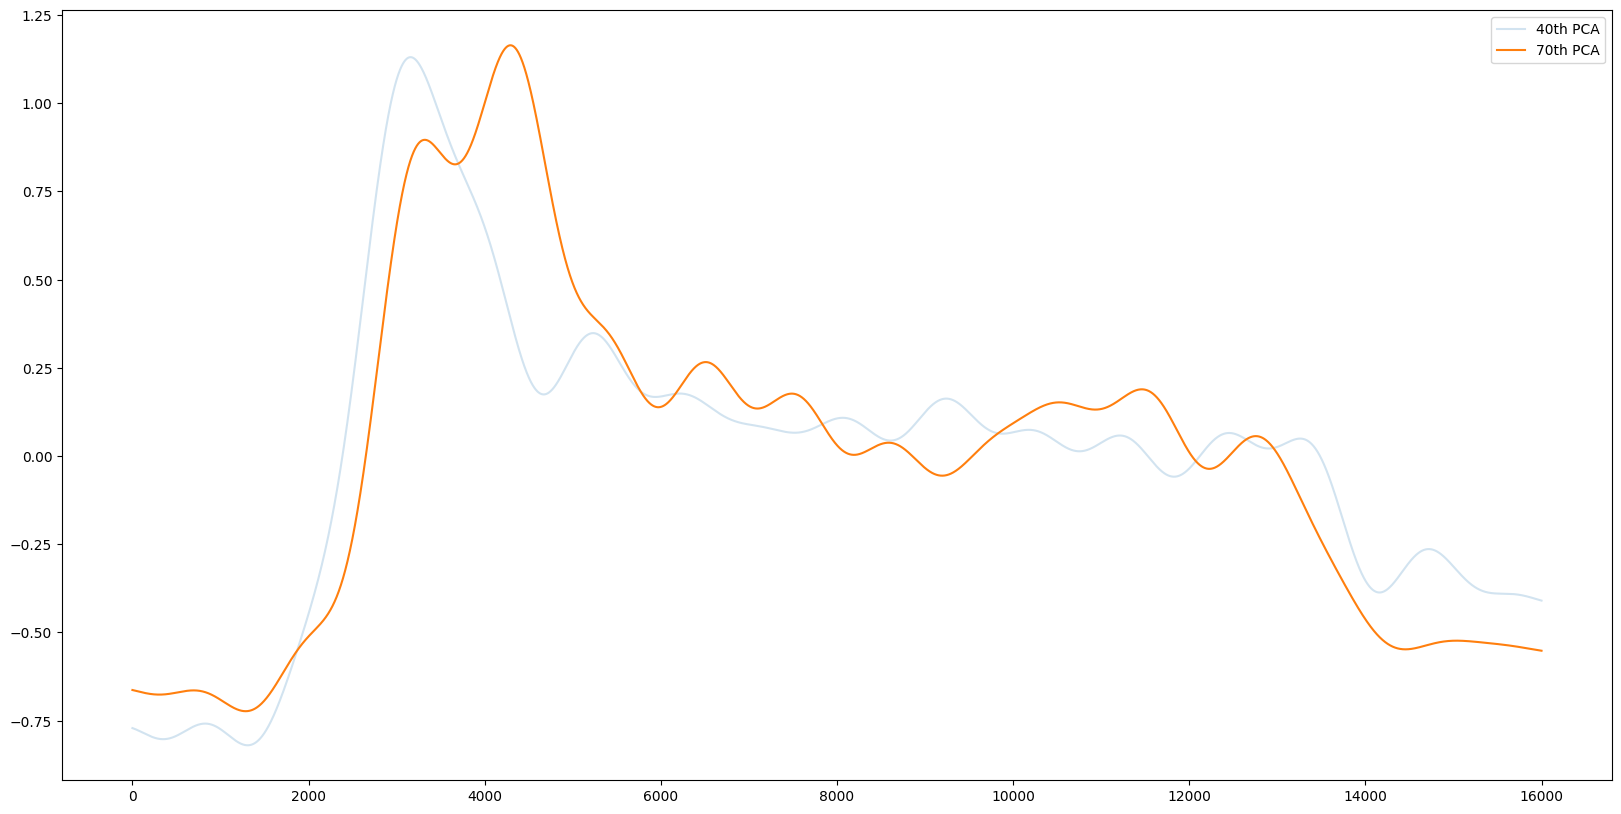

In [45]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_pca,label='40th PCA',alpha=0.2)
ax.plot(X70_pca,label='70th PCA')

plt.legend()
plt.show()

2. t-SNE(t-distributed Stochastic Neighbor Embedding)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=1)
X40_tsne = tsne.fit_transform(X40_mm)
X70_tsne = tsne.fit_transform(X70_mm)

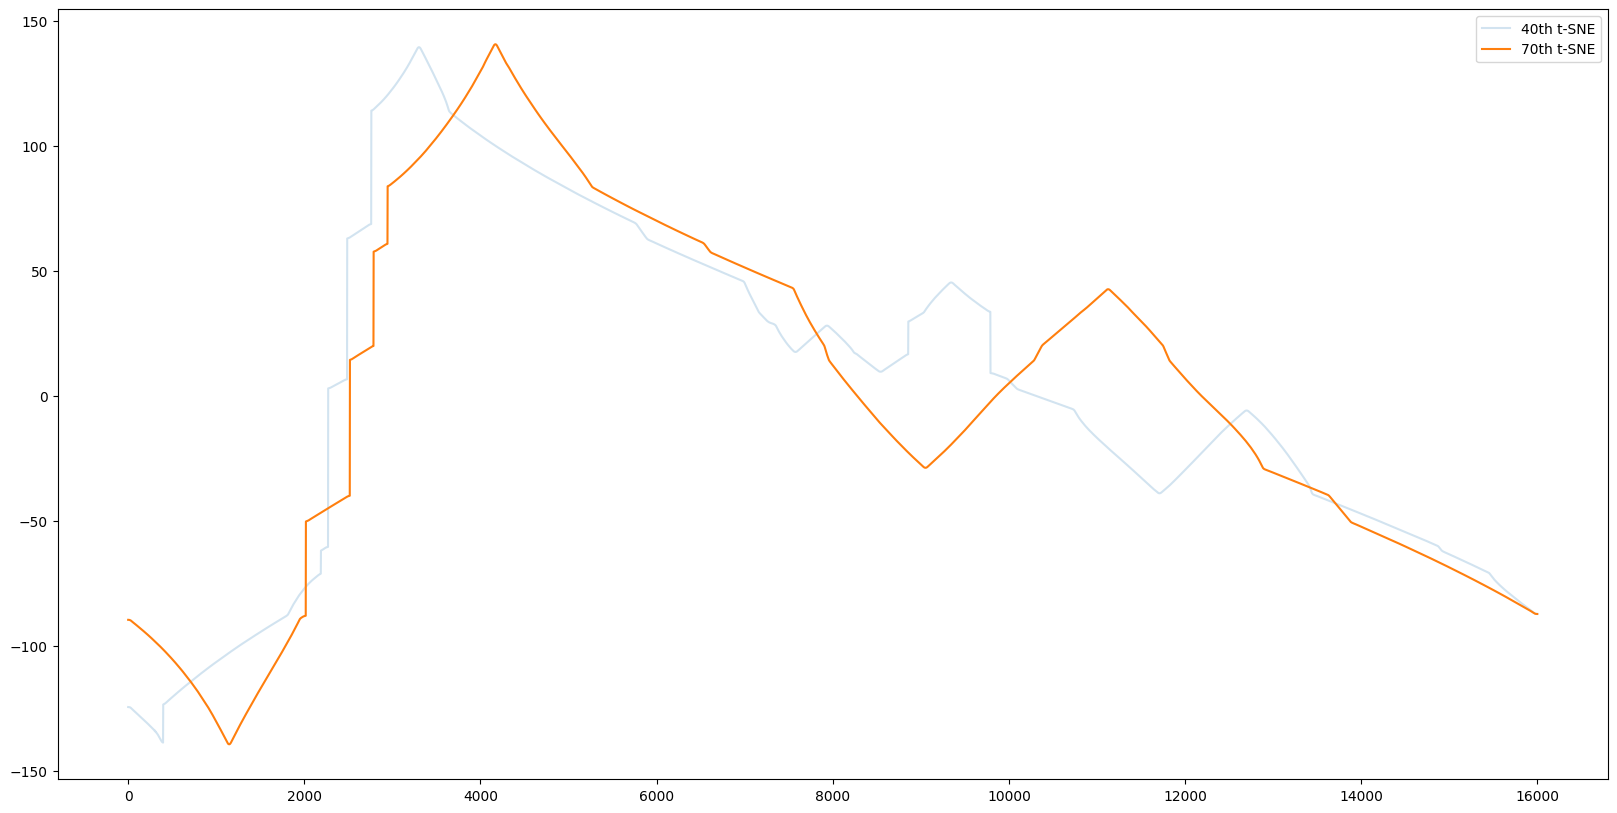

In [46]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(X40_tsne,label='40th t-SNE',alpha=0.2)
ax.plot(X70_tsne,label='70th t-SNE')

plt.legend()
plt.show()

In [ ]:
"""
for i in range(40): #data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for f in col_names: #ch1 to ch4
        
        for j in range(5): #pattern1 to pattern5
            
            for g in range(10): #gesture1 to gesture10
                if g == 0: #make a dataframe what sets the standard index
                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]) #new dataframe to set columns as gestures

                else: #appending the other features by pd.concat
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.concat([globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)],pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]).set_index(globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].index)],axis=1,join='inner')
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index

                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)] = globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].iloc[3000:17000] #new dataframe with a little of the rest time(0:4000, 16000:20000)
                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index
            
            globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
            globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
"""

"\nfor i in range(40): #data1 to data40\n    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)\n\n    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time\n\n    for f in col_names: #ch1 to ch4\n        \n        for j in range(5): #pattern1 to pattern5\n            \n            for g in range(10): #gesture1 to gesture10\n                if g == 0: #make a dataframe what sets the standard index\n                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures\n                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFr

In [ ]:
"""
#Remove 'Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers' (no remarkable signal characteristic between two similar)
for i in range(40):
    for j in range(4):
        for k in range(5):
            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)
"""

"\nfor i in range(40):\n    for j in range(4):\n        for k in range(5):\n            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)\n"